# Explaining models decisions using SHAP - Hear Attack Prediction

## Report


### 1. Model training, 2. calculating model predictions and 3. SHAP decomposition
First a model (Random Forest) was trained on the preprocessed dataset. Then, two arbitrary samples were selected for decomposition of predictions. Both samples were explained using two libraries: `dalex` and `shap`.
The decomposition is presented with waterfall plots.

### 4. Different variables can be the most important
What we can see is that the most important variable for the model depends on the given sample. For patient 0, the most important variable is `cp_0`, whereas for patient 1 it is `caa`. The same result holds for both libraries.

Results with dalex:

![alt text](images/1.png "Samples with dalex")

Results with shap:

![alt text](images/2.png "Samples with shap")
![alt text](images/3.png "Samples with shap")

### 5. A variable can contribute positively or negatively
Next I found a feature in the model which can contribute both positively or negatively to the prediction depending on the sample. It is `cp_3`. The same result can be seen no matter which library is used.

![alt text](images/4.png "cp_3 contributes negatively (dalex)")
![alt text](images/5.png "cp_3 contributes positively (dalex)")
![alt text](images/6.png "cp_3 contributes in different ways (shap)")

### 6. `shap` and `dalex` comparison
Both libraries give similar results, however there are some minor discrepancies in the attribution scores. Because `shap` is optimized for use with tree-based models, it is much faster than `dalex` in the setting used in my experiments (random forest).

### 7. Training a different model
I also trained another model (linear regression) on the same task. Its explanation is different from the explanation of the random forest. For example `cp_3` is not important when explaining the random forest, but it is one of the most important variable in the linear regression for patient 1.
On the given examples explanations with respect to different models are rather similar.

![alt text](images/7.png "Linear regression")

### 8. Final remarks
All the salient points of the analysis are present in the above sections. The code used for generation of the report is provided in the `Appendix`.

## Appendix

### Install dependencies

In [34]:
!pip install -U pip 'dalex==1.5.0' 'shap==0.41.0' 'nbformat>=4.2.0' 'scikit-learn==1.0.2' 'pandas==1.3.5' 'numpy==1.22.4'

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.9-py2.py3-none-any.whl/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
/usr/share/python-wheels/urllib3-1.25.9-py2.py3-none-any.whl/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
     |████████████████████████████████| 2.1 MB 1.8 MB/s eta 0:00:01
/usr/share/python-wheels/urllib3-1.25.9-py2.py3-none-any.whl/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is st

### Download data

In [1]:
import gdown
gdown.download(id='1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c', output='heart.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c
To: /home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW2/MaciejPióro/heart.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 25.2MB/s]


'heart.csv'

### Load & Preprocess data
First the data is loaded and some test set size is selected. To make the analysis reproducible, the seed is set.


In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dalex as dx
import shap
from sklearn.utils import shuffle

SEED = 997
TEST_SIZE = 0.1

data = shuffle(pd.read_csv('heart.csv'), random_state=SEED)

Dataset contains two categorical variable: `cp` and `restecg`. Those are one-hot encoded in preprocessing. All models used (Logistic Regression, Decision Tree, Random Forest) can benefit from one-hot encoding the categorical variables.

In [160]:
def to_one_hot(data, column):
    dummies = pd.get_dummies(data[column])
    for dummy_value in dummies.columns:
        data = pd.concat([data, dummies[dummy_value].rename(f'{column}_{dummy_value}')], axis=1)
    return data.drop(column, axis=1)

data = to_one_hot(data, 'cp')
data = to_one_hot(data, 'restecg')

X = data.drop(columns=['output'])
y = data['output']

Get binary columns. It will be useful later

In [178]:
binary_columns = []
for c in X.columns:
    possible_values = X[c].unique()
    num_values = possible_values.shape[0]
    if list(sorted(possible_values)) == [0, 1]:
        binary_columns.append(c)
        print(c)


sex
fbs
exng
cp_0
cp_1
cp_2
cp_3
restecg_0
restecg_1
restecg_2


### 1. Train a model
The basic model that we use is Random Forest Classifier

In [164]:
import dalex as dx
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)

model.fit(X, y)

RandomForestClassifier(random_state=997)

### 2. Evaluate model
The model is evaluated on two arbitrary examples

In [184]:
print('Predicted classes')
print(model.predict(X[:2]))
print('Predicted probabilities')
print(model.predict_proba(X[:2]))


Predicted classes
[1 0]
Predicted probabilities
[[0.01 0.99]
 [0.81 0.19]]


### 3a. Evaluate model using dalex

Attribute contribution decomposition for two first samples from the dataset is computed and plotted. The package used is `dalex`.

In [185]:
pf = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, X, y, predict_function=pf)

shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'patient {i}', random_state=SEED) for i in range(2)]
shap_attributions[0].plot(shap_attributions[1:])

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function <lambda> at 0x7fbdeeebb0d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.544, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.33, mean = 0.000297, max = 0.4
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



### 3b. Evaluate model using shap

Attribute contribution decomposition for two first samples from the dataset is computed and plotted. The package used is `shap`.

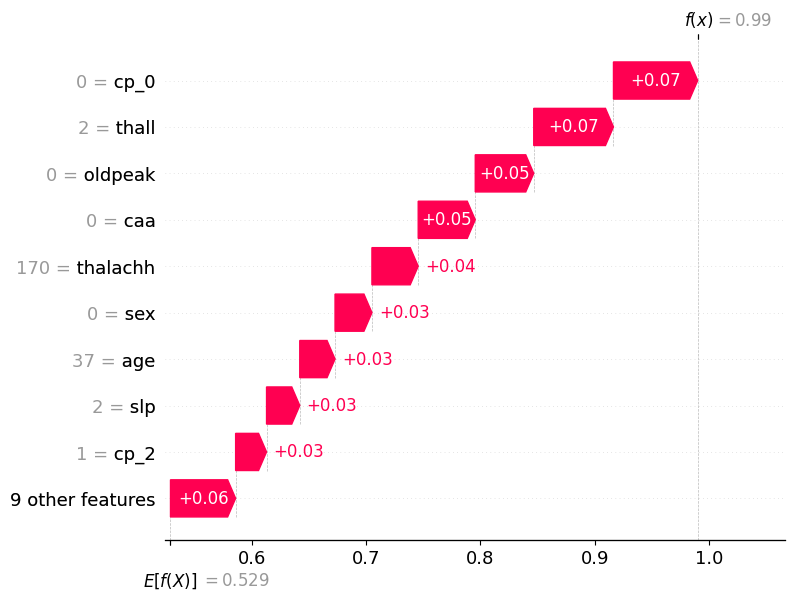

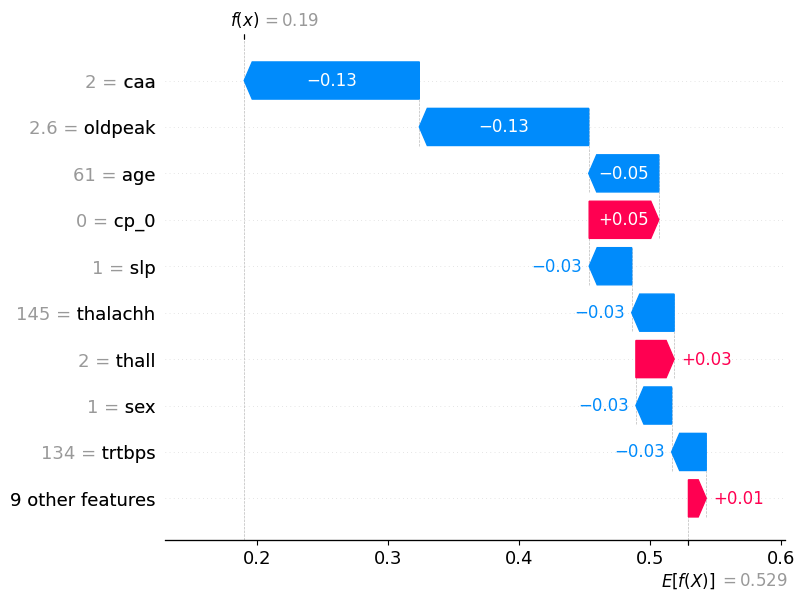

In [186]:
shap_explainer = shap.explainers.Tree(model, data=X, model_output='probability', random_state=SEED)
shap_values = shap_explainer(X)[:,:,1]

for i in [0, 1]:
    shap.plots.waterfall(shap_values[i])

### 4. Observations with different most important variables
The samples used in points 3a, 3b differ when it comes to the most important variables. 
For the first sample, the most important variables are `cp_0` and `thall`.
For the second sample, the most important variables are `caa` and `oldpeak`.
This point of the analysis is only conducted in `shap` since it allows for much faster computation than `dalex`.

### 5. Variable contributing positively in some examples and negatively in others

First, let us find a binary variable set to `1`, whose contribution is positive in some samples, negative in others and its magnitude is sufficiently high.

In [187]:
def sign(x):
    if x > 0:
        return 1
    elif x==0:
        return 0
    else:
        return -1

interesting_variables = set()
contributions = {}
for i, exp in enumerate(shap_values):
    for name, contribution, value in zip(exp.feature_names, exp.values, exp.data):
        if name in binary_columns and value == 1 and abs(contribution) > 0.03:
            if name not in contributions:
                contributions[name] = sign(contribution)
            if sign(contribution) != contributions[name]:
                print(i)
                interesting_variables.add(name)
print(interesting_variables)


99
{'cp_3'}


Knowing the variable is `cp_3` and the sample where it is negative is `99`, let us select another sample where `cp_3`'s contribution is positive and quite large.

In [176]:
for i, exp in enumerate(shap_values):
    for name, contribution, value in zip(exp.feature_names, exp.values, exp.data):
        if name =='cp_3' and abs(contribution) > 0.1:
            print(i)

41


Compare the contribution of `cp_3` in the following examples:

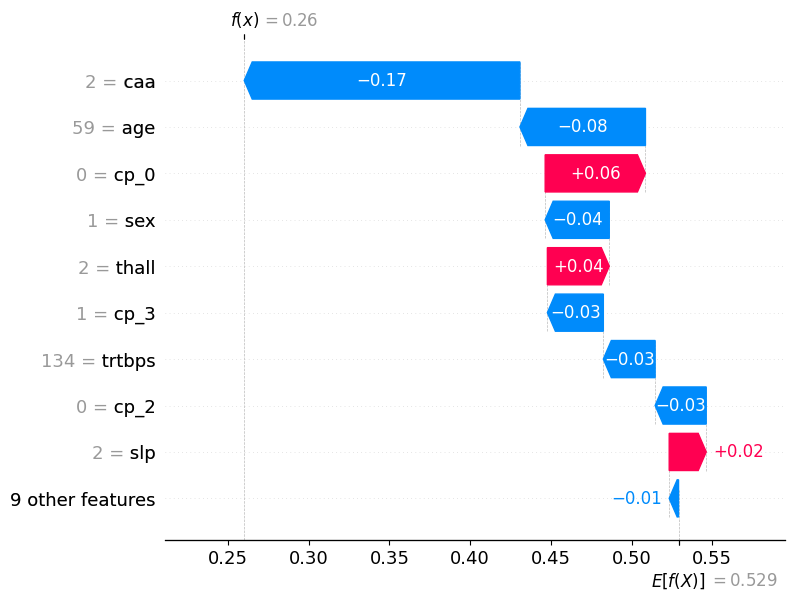

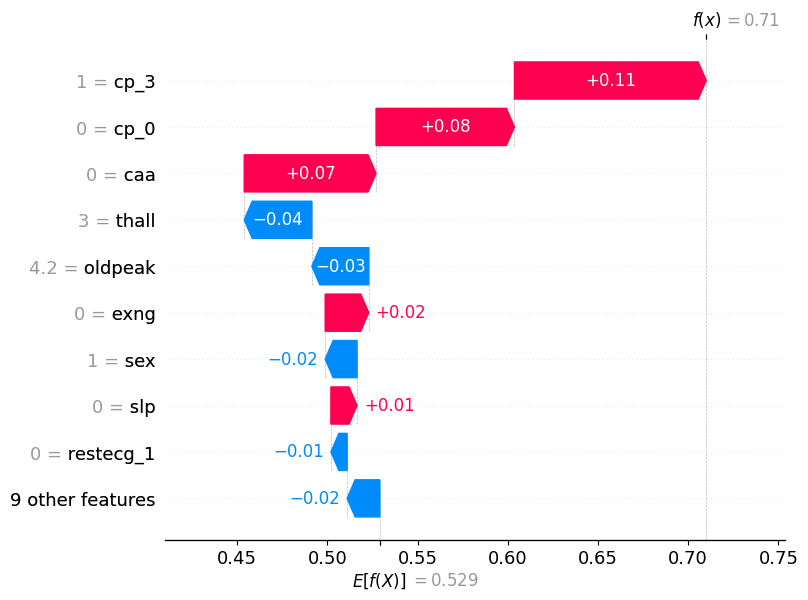

In [189]:
interesting_samples = [99, 41]

for i in interesting_samples:
    shap.plots.waterfall(shap_values[i])

shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'patient {i}', random_state=SEED) for i in interesting_samples]
shap_attributions[0].plot(shap_attributions[1:])

### 6. Packages comparison
No code is needed. Previous cells are enough.

### 7. Different model evaluated using dalex

In [194]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=SEED, max_iter=5000)

model.fit(X, y)

pf = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, X, y, predict_function=pf)

shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'patient {i}', random_state=SEED) for i in range(2)]
shap_attributions[0].plot(shap_attributions[1:])

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function <lambda> at 0x7fbdeeebbca0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00166, mean = 0.545, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.961, mean = -2.34e-06, max = 0.955
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

